# Multi-class Classification Mneggunkan Model BERT
### Oleh :
- Marco Aland Adinanda

In [1]:
!nvidia-smi

Sat Jun  1 09:37:57 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.06       Driver Version: 522.06       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P5    12W /  N/A |    404MiB /  6144MiB |     40%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Load and Analyze the Datasets

### 1.a. Load and clean the dataset

In [2]:
# importing dependencies
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import shutil
import sys   
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

c:\Users\acer\miniconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [3]:
# data path 
used_path = "../data/dataset_penyisihan_bdc_2024.xlsx" 
test_path = "../data/dataset_unlabeled_penyisihan_bdc_2024.xlsx"

used_df = pd.read_excel(used_path)
test_df = pd.read_excel(test_path)

In [4]:
# first look 
used_df.head()

,text,label
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik


In [5]:
# check duplicate values
used_df['text'].duplicated().value_counts()

text
False    4583
True      417
Name: count, dtype: int64

In [6]:
# Check null Values
used_df.isna().sum()

text     0
label    0
dtype: int64

In [7]:
# Clean the Dataset
used_df = used_df.drop_duplicates()

### 1.b. Mini EDA and Preprocessing

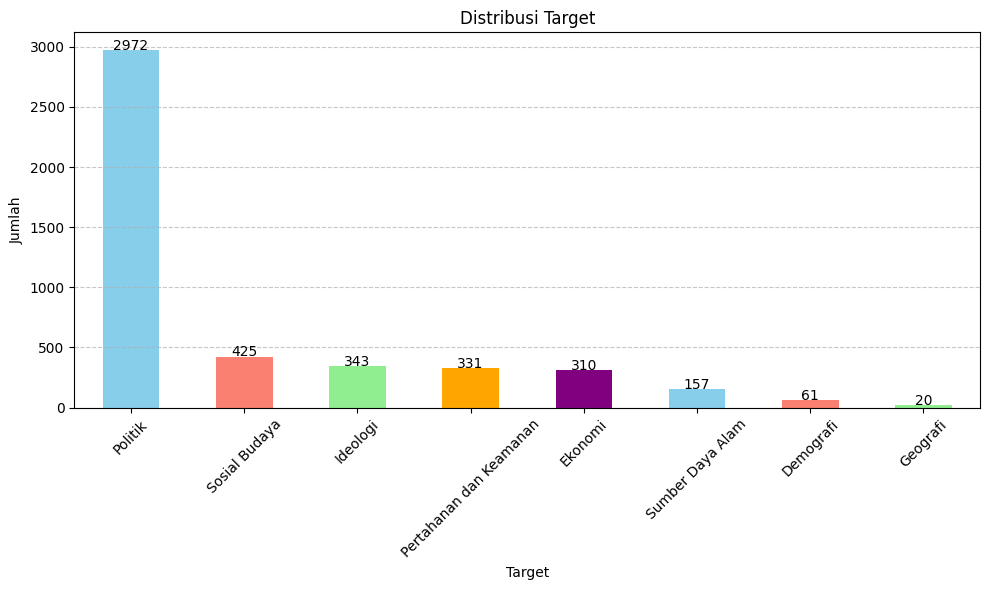

In [8]:
# target distribution
value_counts = used_df['label'].value_counts()

plt.figure(figsize=(10, 6))
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'purple']
ax = value_counts.plot(kind='bar', color=colors)

for i, count in enumerate(value_counts):
    ax.text(i, count + 0.1, str(count), ha='center', color='black')

plt.title('Distribusi Target')
plt.xlabel('Target')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout()  
plt.show()

In [9]:
# one hot encoding the classes
used_df = pd.get_dummies(used_df, prefix=["label"], columns=["label"], dtype=int)
used_df.head()

,text,label_Demografi,label_Ekonomi,label_Geografi,label_Ideologi,label_Pertahanan dan Keamanan,label_Politik,label_Sosial Budaya,label_Sumber Daya Alam
0,Kunjungan Prabowo ini untuk meresmikan dan men...,0,0,0,0,0,0,0,1
1,RT Anies dapat tepuk tangan meriah saat jadi R...,0,0,0,0,0,1,0,0
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,1,0,0,0,0,0,0,0
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,0,0,0,0,0,1,0,0
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,0,0,0,0,0,1,0,0


In [10]:
# assigning targets
target_list = used_df.columns[1:]
print(target_list)

Index(['label_Demografi', 'label_Ekonomi', 'label_Geografi', 'label_Ideologi',
       'label_Pertahanan dan Keamanan', 'label_Politik', 'label_Sosial Budaya',
       'label_Sumber Daya Alam'],
      dtype='object')


In [11]:
# class weighting
class_counts = used_df[target_list].sum()
total_samples = used_df.shape[0]

class_weights = total_samples / (len(class_counts) * class_counts)
print(class_weights)

label_Demografi                   9.465164
label_Ekonomi                     1.862500
label_Geografi                   28.868750
label_Ideologi                    1.683309
label_Pertahanan dan Keamanan     1.744335
label_Politik                     0.194272
label_Sosial Budaya               1.358529
label_Sumber Daya Alam            3.677548
dtype: float64


In [12]:
# to GPU
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

C:\Users\acer\AppData\Local\Temp\ipykernel_22748\687613656.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)


## 2. Training Process

### 2.a. Defining Parameters

In [13]:
# hyperparameters
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 1e-05

In [14]:
tokenizer = BertTokenizer.from_pretrained('cahya/bert-base-indonesian-522M')

### 2.b. Data Processing

In [15]:
class BDCdataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['text']
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }

In [16]:
train_df, val_df = train_test_split(used_df, test_size=0.2, random_state=42)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)


In [17]:
train_df.shape, val_df.shape

((3695, 9), (924, 9))

In [18]:
train_dataset = BDCdataset(train_df, tokenizer, MAX_LEN)
valid_dataset = BDCdataset(val_df, tokenizer, MAX_LEN)

In [19]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

### 2.c. Model Preparation

In [20]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    valid_loss_min = checkpoint['valid_loss_min']
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)

In [21]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('cahya/bert-base-indonesian-522M', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, len(target_list))
    
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [22]:
# implement the class weight
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss(weight=class_weights_tensor)(outputs, targets)

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

### 2.d. Training Process

In [23]:
val_targets=[]
val_outputs=[]

In [24]:
def train_model(n_epochs, training_loader, validation_loader, model, 
                optimizer, checkpoint_path, best_model_path, patience):
  
  valid_loss_min = np.Inf
   
  # Training Set
  for epoch in range(1, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(tqdm(training_loader)):
      ids = data['input_ids'].to(device, dtype = torch.long)
      mask = data['attention_mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)

      outputs = model(ids, mask, token_type_ids)

      optimizer.zero_grad()
      loss = loss_fn(outputs, targets)
        
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Calculating loss
      train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
    print('############# Epoch {}: Training End     #############'.format(epoch))
    
    # Validation Set
    print('############# Epoch {}: Validation Start   #############'.format(epoch)) 
    model.eval()
    with torch.no_grad():
      for batch_idx, data in enumerate(tqdm(validation_loader), 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
      print('############# Epoch {}: Validation End     #############'.format(epoch))
      
      # Evaluationg
      n_patience = 0
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)

      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
      
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
        
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
      # save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
         print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
         # save checkpoint as best model
         save_ckp(checkpoint, True, checkpoint_path, best_model_path)
         valid_loss_min = valid_loss
      else:
         n_patience += 1

    print('############# Epoch {}  Done   #############\n'.format(epoch))
    
    # EarlyStoping
    if n_patience == patience:
      break
      
  return model

In [25]:
ckpt_path = "../checkpoints/current_ckpt"
best_model_path = "../models/best_model.pt"

In [27]:
trained_model = train_model(EPOCHS, train_data_loader, val_data_loader, model, optimizer, ckpt_path, best_model_path, patience=5)

############# Epoch 1: Training Start   #############


  0%|          | 0/231 [00:00<?, ?it/s]c:\Users\acer\miniconda3\envs\pytorch\lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 231/231 [00:55<00:00,  4.18it/s]


############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############


100%|██████████| 58/58 [00:04<00:00, 12.15it/s]


############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.003103 	Average Validation Loss: 0.007455


RuntimeError: [enforce fail at inline_container.cc:595] . unexpected pos 498263616 vs 498263504

### 3. Evaluation

In [ ]:
# def test_model(input):
#     encodings = tokenizer.encode_plus(
#         input,
#         None,
#         add_special_tokens=True,
#         max_length=MAX_LEN,
#         padding='max_length',
#         return_token_type_ids=True,
#         truncation=True,
#         return_attention_mask=True,
#         return_tensors='pt'
#         )
    
#     model.eval()
#     with torch.no_grad():
#         input_ids = encodings['input_ids'].to(device, dtype=torch.long)
#         attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
#         token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
#         output = model(input_ids, attention_mask, token_type_ids)
#         final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
#         # print(target_list[int(np.argmax(final_output, axis=1))])
#         return target_list[int(np.argmax(final_output, axis=1))]

In [ ]:
def test_model_dataloader(data_loader):
    predictions = []
    true_label = [] 
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            list_true_label = batch['targets'].cpu().detach().numpy().tolist()
            true_label.extend([target_list[value.index(1.0)] for value in list_true_label])
            # true_label.extend(batch['targets'].cpu().detach().numpy().tolist()) #####
            output = model(input_ids, attention_mask, token_type_ids)
            final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
            predictions.extend([target_list[int(np.argmax(pred))] for pred in final_output])
    return true_label, predictions


In [ ]:
val_true_target, val_predictions = test_model_dataloader(val_data_loader)

true_labels = val_true_target
predicted_labels = val_predictions

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# # testing
# example = test_df['Text'][1]
# encodings = tokenizer.encode_plus(
#     example,
#     None,
#     add_special_tokens=True,
#     max_length=MAX_LEN,
#     padding='max_length',
#     return_token_type_ids=True,
#     truncation=True,
#     return_attention_mask=True,
#     return_tensors='pt'
# )
# model.eval()
# with torch.no_grad():
#     input_ids = encodings['input_ids'].to(device, dtype=torch.long)
#     attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
#     token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
#     output = model(input_ids, attention_mask, token_type_ids)
#     final_output = torch.softmax(output).cpu().detach().numpy().tolist()
#     print(target_list[int(np.argmax(final_output, axis=1))])